In [3]:
import os
import torch
import torchvision
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


In [4]:
# preprocessing
fake_news_frame = pd.read_csv('fake_and_real_news/Fake.csv')
true_news_frame = pd.read_csv('fake_and_real_news/True.csv')

# add authenticity label


fake_column = ["Fake"] * len(fake_news_frame)
#print(len(fake_column))

fake_news_frame.insert(4, 'authenticity', fake_column)
#fake_news_frame.to_csv(path_or_buf='fake_and_real_news/NewFake.csv')


true_column = ["True"] * len(true_news_frame)
#print(len(true_column))

true_news_frame.insert(4, 'authenticity', true_column)
#true_news_frame.to_csv(path_or_buf='fake_and_real_news/NewTrue.csv')


# combine datasets

frames = [fake_news_frame, true_news_frame]
combined_news_frame = pd.concat(frames)

combined_news_frame.to_csv(path_or_buf='fake_and_real_news/Combined.csv')

In [5]:
news_frame = pd.read_csv('fake_and_real_news/Combined.csv')

n = 1
title = news_frame.iloc[n, 1]
text = news_frame.iloc[n, 2]
subject = news_frame.iloc[n, 3]
date = news_frame.iloc[n, 4]
authenticity = news_frame.iloc[n, 5]

print('Title: {}'.format(title))
print('Text: {}'.format(text))
print('Subject: {}'.format(subject))
print('Date: {}'.format(date))
print('Authenticity: {}'.format(authenticity))

Title:  Drunk Bragging Trump Staffer Started Russian Collusion Investigation
Text: House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys  don t help to arrange a New York meeting between Trump and President Abdel Fattah el-Sisi of Egypt two months before the election. It was known bef

In [6]:
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html


class NewsDataset(Dataset):
    """ News dataset. """
    
    def __init__(self, csv_file, root_dir):
        """Args:
            csv_file (string): Path to the news csv file.
            root_dir (string): Path to the root directory
        """
        
        self.news_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.news_frame)
    
    
    def __getitem__(self, idx):
        news = self.news_frame.iloc[idx, 1:]
        
        # we are going to have to make some way to parse text as words, and to feed it to the NN
        
        return news

In [7]:
news_dataset = NewsDataset('fake_and_real_news/Combined.csv', 'fake_and_real_news/')

In [8]:
# processing: populate text dataset with news article texts

rows = np.arange(len(news_dataset))

text_dataset = []

for idx in range(0, len(news_dataset)):
    text_dataset.append(news_dataset[idx][1])

In [9]:
pip install --user -U nltk

Requirement already up-to-date: nltk in /home/paul/.local/lib/python3.6/site-packages (3.5)
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [10]:
# processing: encode one news article using nltk encoder
import nltk

from torchnlp.encoders.text import TreebankEncoder


encoder = TreebankEncoder(text_dataset)
encoder.encode("Test input.")
print(len(encoder.vocab))

encoder.encode(text_dataset[10923])

#lineno = 0

#for text in text_dataset.values():
#    encoder.encode(text)
#    if lineno % 5000 == 0:
#        print(lineno)
#    lineno += 1

[nltk_data] Downloading package perluniprops to
[nltk_data]     /home/paul/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /home/paul/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!


296562


tensor([])

In [11]:
encoder.encode(text_dataset[10923])

tensor([])

In [12]:
lineno = 0

lengths = []

for text in text_dataset:
    lengths.append(len(encoder.encode(text)))
    lineno += 1
    if lineno % 5000 == 0:
        print(lineno, "lineno")
        print(len(encoder.encode(text)), "len")
        print(text)

# MAX_TEXT_LENGTH = max(lengths)

average_len = sum(lengths)/len(lengths)
print(average_len)

TEXT_LENGTH = round(average_len)

5000 lineno
398 len
As Donald Trump s campaign continues to sink deeper into its self-sabotaging downward spiral, it s becoming clear that even Trump s campaign surrogates and former staffers are having trouble trying to stay positive about the outcome of this election. In just the past few days, we ve seen them completely deny that Trump s campaign made some massive changes in desperation, ignore polls that The Donald is losing and now thanks to former Trump campaign manager Corey Lewandowski, they re holding onto false hope that Trump can still somehow win this.Earlier today on CNN, Lewandowski   who is forbidden by contract to say anything negative about Trump   tried to convince everyone that Trump was still on track to win this election because his biggest opponent, Democratic nominee Hillary Clinton, was losing voters to Green Party candidate Jill Stein and Libertarian Party candidate Gary Johnson. Lewandowski said: This is not a two-person race. Gary Johnson and Jill Stein are i

In [13]:
lengths[2]

671

In [14]:
TEXT_LENGTH

435

In [15]:
# processing: pad texts to have matching length

from torchnlp.encoders import Encoder
from torchnlp.encoders.text import pad_tensor
from torchnlp.encoders.text.default_reserved_tokens import DEFAULT_PADDING_INDEX

lineno = 0

padded_texts = []

print(encoder.encode(text_dataset[5])[0:TEXT_LENGTH])
print(text_dataset[5])
print(lengths[5])
print(len(encoder.encode(text_dataset[5])[0:TEXT_LENGTH]))
print(len(encoder.encode(text_dataset[5])))
# print(encoder.encode(text_dataset[5])[TEXT_LENGTH])

for text in text_dataset:
    if len(encoder.encode(text)) < TEXT_LENGTH:
        padded_texts.append(pad_tensor(encoder.encode(text).long(), TEXT_LENGTH))
#         print(len(pad_tensor(encoder.encode(text).long(), TEXT_LENGTH)))
    if len(encoder.encode(text)) > TEXT_LENGTH:
        padded_texts.append(encoder.encode(text)[0:TEXT_LENGTH])
    if len(encoder.encode(text)) == TEXT_LENGTH:
        padded_texts.append(encoder.encode(text))
    if lineno % 5000 == 0:
        print(lineno)
    lineno += 1

tensor([  39,  696,   57,  997,   57,  998,  999,   17, 1000,  155,   57, 1001,
        1002,   26,  463,  449, 1003, 1004,   23,  673,  151, 1005, 1006,  153,
        1007,   26,   72, 1008, 1009,   17, 1010, 1011, 1012, 1013,  268,   33,
         843,   57, 1014, 1015, 1008,   13, 1016, 1017,   57, 1018, 1019,   23,
         408,  168,   13, 1020, 1021,  354,   13, 1022,   17, 1023, 1024,   23,
         317, 1025,  348, 1007,   26,   72, 1008, 1009,   17, 1026,   23,  542,
         102,  195, 1027,  195,  385, 1028, 1015, 1019,  286,  168,  448, 1029,
         574,  191, 1030,   57, 1031, 1032,  168,   30, 1033,   23,  136,  311,
          94,  463,   33, 1017,   94,   71, 1034,  153,  490, 1035, 1036, 1037,
        1038,  215,  217, 1039,   26, 1040,   17, 1041,  183,  168,  398, 1042,
        1043,   33, 1044,   94,  215,   91,   26,  463,   23, 1045, 1015, 1046,
        1018,  562,  153,   33,  998,   25,  398, 1047, 1048,  317,  844,  159,
         262, 1049, 1018, 1019,   23,  1

In [16]:
# processing: convert longs to floats (for NN)

# lineno = 0

# for text in padded_texts:
#     for long in text:
#         long = float(long)
#     if lineno % 5000 == 0:
#         print(lineno)
#     lineno += 1

In [17]:
len(padded_texts[10])

435

In [18]:
# processing: split news article texts into strings, store in dictionary

# dictionary = []
# lengths = []

# split_texts = []
# lineno = 0

# for text in text_dataset.values():
#     text_words = text.split()
#     split_texts.append(text_words)
#     #print(len(text), lineno)
#     lengths.append(len(text))
#     lineno += 1
#     for word in text_words:
#         if word not in dictionary:
#             dictionary.append(word)

            
# MAX_TEXT_LENGTH = max(lengths)
# print(MAX_TEXT_LENGTH)


In [19]:
# processing: pad data to provide uniform input to NN

# dictionary = {'fake': 0, 'true': 1}


###

# random train data to test NN

# split_texts = []

# split_texts.append(['fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake'])
# split_texts.append(['fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake'])
# split_texts.append(['fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake'])
# split_texts.append(['fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake'])
# split_texts.append(['true', 'true', 'true', 'true', 'true', 'true', 'true'])
# split_texts.append(['true', 'true', 'true', 'true', 'true', 'true', 'true'])
# split_texts.append(['true', 'true', 'true', 'true', 'true', 'true', 'true'])
# split_texts.append(['true', 'true', 'true', 'true', 'true', 'true', 'true'])

# MAX_TEXT_LENGTH = 7

###

# for text in split_texts:
#     while len(text) < MAX_TEXT_LENGTH:
#         text.append('word')

In [20]:
# processing: convert split texts (lists of strings) into lists of ints, using dictionary

# converted_split_texts = []

# for text in split_texts:
#     converted_text = []
#     for word in text:
#         converted_text.append(dictionary[word])
#     converted_split_texts.append(converted_text)
    
# print(converted_split_texts)

In [21]:
# processing: collect vector of true/fake booleans to train dataset

rows = np.arange(len(news_dataset))

true_fake_dataset = []

lineno = 0

for idx in np.nditer(rows):
    if news_dataset[int(idx)][4] == 'Fake':
        true_fake_dataset.append(torch.Tensor([0]))
    if news_dataset[int(idx)][4] == 'True':
        true_fake_dataset.append(torch.Tensor([1]))
    if lineno % 5000 == 0:
        print(lineno)
    lineno += 1
        
###

# random train data to test NN

# true_fake_dataset = [0, 0, 0, 0, 1, 1, 1, 1]

###

0
5000
10000
15000
20000
25000
30000
35000
40000


In [22]:
# processing: add true/fake label to padded_texts

print(len(padded_texts))
print(len(true_fake_dataset))
print(len(text_dataset))

trainset = []

lineno = 0

for idx, text in enumerate(padded_texts):
    if lineno % 5000 == 0:
#         print(padded_texts[idx][0])
#         print(len(padded_texts[idx]))
        print(lineno)
    lineno += 1
    trainset.append((text, true_fake_dataset[idx]))

44898
44898
44898
0
5000
10000
15000
20000
25000
30000
35000
40000


In [23]:
trainset[30000][1]

tensor([1.])

In [24]:
trainset[0:10]

[(tensor([  5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
           19,  20,  21,  22,  23,  24,  25,  26,  27,  13,  28,  29,  26,  30,
           31,  23,  32,  17,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
           43,  25,   7,  44,  45,  26,  46,  17,  24,   8,   9,  46,  47,  48,
           49,  50,  51,  52,  53,  17,  54,  23,  55,  56,  26,  10,  11,  57,
           58,  59,  23,  60,  23,  31,  23,  32,  23,  17,  61,  33,  34,  35,
           62,  63,  64,  23,  13,  14,  17,  65,  15,  16,  23,  66,  67,  68,
           69,  70,  71,  72,  13,  73,  74,  75,  76,  77,  48,  49,  50,  51,
           52,  53,  17,  54,  23,  55,  56,  26,  10,  11,  57,  58,  59,  23,
           60,  23,  31,  23,  32,  23,  17,  61,  33,  34,  35,  62,  63,  64,
           23,  13,  14,  17,  65,  15,  78,  70,  71,  72,  13,  73,  74,  75,
           76,  77,   5,  79,   6,  80,  81,  82,  83,  84,  85,  23,  86,  87,
           88,  89,  90,  91,  92,  93, 

In [25]:
# define Net class

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(TEXT_LENGTH, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)


In [26]:
# initialize net and print parameters

net = Net()
print(net)

params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

Net(
  (fc1): Linear(in_features=435, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
)
8
torch.Size([64, 435])


In [27]:
# optimize net with backprop; 3 epochs

# import torch.optim as optim

# optimizer = optim.Adam(net.parameters(), lr=0.001)

# EPOCHS = 3


# for epoch in range(EPOCHS):
#     for i, padded_text in enumerate(padded_texts, start=0):
#         # data is a batch of featuresets and labels
#         #print(true_fake_dataset[i])
#         X = padded_text
#         #print(X)
#         y = torch.tensor([true_fake_dataset[i]], dtype=torch.long)
#         if i % 500 == 0:
#             print(i)
#         #print(y)
#         net.zero_grad()
#         X_float = X.new_tensor(X, dtype=torch.float) # convert tensor long to float, NN must read in float
# #         print(X_float)
#         output = net(X_float.view(-1, MAX_TEXT_LENGTH))
#         loss = F.nll_loss(output, y)
#         loss.backward()
#         optimizer.step()
#     print(loss)


In [28]:
# calculate and print accuracy

# correct = 0
# total = 0

# with torch.no_grad():
#     for i, padded_text in enumerate(padded_texts, start=0):
#         X = padded_text
#         y = torch.tensor([true_fake_dataset[i]], dtype=torch.long)
#         X_float = X.new_tensor(X, dtype=torch.float) # convert tensor long to float
#         output = net(X_float.view(-1, MAX_TEXT_LENGTH))
# #         print(torch.argmax(output))
#         for idx, i in enumerate(output):
#             if torch.argmax(i) == y[idx]:
#                 correct += 1
#             total += 1

# print("Accuracy: ", round(correct/total, 3))

In [29]:
# Credit to this source for glove embedding code + initial NN code
# https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76
# import glove relations

import bcolz
import pickle

words = []
idx = 0
word2idx = {}
vectors = bcolz.carray(np.zeros(1), rootdir=f'6B.50.dat', mode='w')


with open(f'glove.6B.50d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)
#         print(vectors[idx])
    
# print(vectors[20000000:20000050])
    
# save outputs to disk    

vectors = bcolz.carray(vectors[1:].reshape((400001, 50)), rootdir=f'6B.50.dat', mode='w')
vectors.flush()
pickle.dump(words, open(f'6B.50_words.pkl', 'wb'))
pickle.dump(word2idx, open(f'6B.50_idx.pkl', 'wb'))

In [30]:
# create glove dictionary

vectors = bcolz.open(f'6B.50.dat')[:]
words = pickle.load(open(f'6B.50_words.pkl', 'rb'))
word2idx = pickle.load(open(f'6B.50_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

In [31]:
glove['<unk>']

array([ 0.072617, -0.51393 ,  0.4728  , -0.52202 , -0.35534 ,  0.34629 ,
        0.23211 ,  0.23096 ,  0.26694 ,  0.41028 ,  0.28031 ,  0.14107 ,
       -0.30212 , -0.21095 , -0.10875 , -0.33659 , -0.46313 , -0.40999 ,
        0.32764 ,  0.47401 , -0.43449 ,  0.19959 , -0.55808 , -0.34077 ,
        0.078477,  0.62823 ,  0.17161 , -0.34454 , -0.2066  ,  0.1323  ,
       -1.8076  , -0.38851 ,  0.37654 , -0.50422 , -0.012446,  0.046182,
        0.70028 , -0.010573, -0.83629 , -0.24698 ,  0.6888  , -0.17986 ,
       -0.066569, -0.48044 , -0.55946 , -0.27594 ,  0.056072, -0.18907 ,
       -0.59021 ,  0.55559 ])

In [32]:
# populate weights matrix for entire vocab of encoder

matrix_len = len(encoder.vocab)
weights_matrix = np.zeros((matrix_len, 50))
words_found = 0

for i, word in enumerate(encoder.vocab):
    try: 
        weights_matrix[i] = glove[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(50))

In [33]:
weights_matrix.shape

(296562, 50)

In [130]:
from torch.autograd import Variable

def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = torch.Tensor(weights_matrix).size()
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': torch.Tensor(weights_matrix)})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

class ToyNN(nn.Module):
    def __init__(self, weights_matrix, hidden_size, num_layers, batch_size, output_size):
        super().__init__()
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.lin = nn.Linear(hidden_size, output_size)
    
    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size))
    
    def forward(self, inp, hidden):
        embedding = self.embedding(inp)
#         print(embedding, "Embedding output")
#         print(embedding.size())
        output, h_n = self.gru(embedding, self.init_hidden(self.batch_size))
#         print(output, "GRU output (output)")
#         print(output.size())
#         print(x.output.view(seq_len, batch, num_directions, hidden_size), "GRU output, (output) unpacked")
#         print(x.h_n, "GRU output (h_n)")
#         print(x.h_n.view(num_layers, num_directions, batch, hidden_size), "GRU output (h_n) unpacked")
        x = F.relu(self.lin(output[:,-1,:]))
#         print(x, "Relu output")
#         print(x.size())
        sm = F.softmax(x, dim=1)
#         print(sm, "Softmax output")
#         print(sm.size())
#         l_sm = F.log_softmax(x, dim=1)
#         print(l_sm, "Log_softmax output")
#         print(l_sm.size())
        return sm

In [131]:
toynet = ToyNN(weights_matrix, 20, 3, 10, 2)

In [132]:
print(toynet)

params = list(toynet.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

ToyNN(
  (embedding): Embedding(296562, 50)
  (gru): GRU(50, 20, num_layers=3, batch_first=True)
  (lin): Linear(in_features=20, out_features=2, bias=True)
)
15
torch.Size([296562, 50])


In [133]:
embedding = nn.Embedding(296562, 50)

output = embedding(torch.stack(padded_texts[0:10]))
# plus_batch = torch.Tensor([3, output])
output.size()

torch.Size([10, 435, 50])

In [134]:
tens = [torch.Tensor([1, 2, 3, 4]), torch.Tensor([5, 6, 7, 8])]
tens = torch.stack(tens)
tens

tensor([[1., 2., 3., 4.],
        [5., 6., 7., 8.]])

In [135]:
stacked_padded_texts = torch.stack(padded_texts)

In [136]:
print(stacked_padded_texts.size())
print(len(padded_texts))
len(padded_texts[10923])

torch.Size([44898, 435])
44898


435

In [137]:
output = toynet(stacked_padded_texts[0:10], torch.zeros([20]))

In [138]:
torch.sum(output)

tensor(10., grad_fn=<SumBackward0>)

In [139]:
len(trainset)

44890

In [140]:
# https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e
# Guide used to code training loop and splitting of dataset, as well as general understanding of model

In [141]:
# truncate dataset to have batch sizes of 10 (TEMPORARY)

trainset.pop(44897)
trainset.pop(44896)
trainset.pop(44895)
trainset.pop(44894)
trainset.pop(44893)
trainset.pop(44892)
trainset.pop(44891)
trainset.pop(44890)


print(len(trainset))

IndexError: pop index out of range

In [142]:
len(trainset)

44890

In [192]:
# split dataset into batches and shuffle them

from torch.utils.data import DataLoader

# train_loader = DataLoader(dataset=trainset, batch_size=10, shuffle=True)

from torch.utils.data.dataset import random_split

# trainset should be "dataset", FIX LATER
# Splits trainset into 200 training articles and 44690 validation articles
train_dataset, val_dataset = random_split(trainset, [40000, 44890-40000])

train_loader = DataLoader(dataset=train_dataset, batch_size=10)
val_loader = DataLoader(dataset=val_dataset, batch_size=10)

In [193]:
(next(iter(train_loader))[1])

tensor([[0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.]])

In [194]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y, lineno):
        # initialize accuracy counter (averaging these accuracies is accurate, as all batches are size 10)
        correct = 0
        total = len(x)
        
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x, torch.zeros([20]))
        
        if lineno % 100 == 0:
            print(yhat, "yhat")
        # Computes loss
        # Create 1D tensor from tensor of single-element lists (FIX IN FUTURE, THIS CAN BE OPTIMIZED EARLIER)
#         init_tensor = next(iter(train_loader))[1]
        init_tensor = y
#         print(init_tensor, "init_tensor")
        cat_list = []
        for val in enumerate(init_tensor):
#             print(val, "val")
            cat_list.append(val[1][0])
#             print(yhat, "predicted vector")
#             print(yhat[val[0]], "predicted val")
            # increment accuracy counter
            if val[1][0] == torch.argmax(yhat[val[0]]):
#                 print(val[1][0], "target val")
#                 print(yhat[val[0]], "predicted val")
                correct += 1
        
        # calculate accuracy
        accuracy = correct/total
#         print(accuracy, "accuracy")
                
        y_target = torch.LongTensor(cat_list)
#         print(y_target)
        
        loss = loss_fn(yhat, y_target)
        
        
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss and accuracy
        return loss.item(), accuracy
#         return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

In [195]:
import torch.optim as optim

# Creates optimizer and train step
lr = 1e-5
n_epochs = 3

loss_fn = nn.NLLLoss()
optimizer = optim.Adam(toynet.parameters(), lr=lr)


tensor([[0.7218, 0.2782],
        [0.6535, 0.3465],
        [0.7475, 0.2525],
        [0.7475, 0.2525],
        [0.7475, 0.2525],
        [0.7475, 0.2525],
        [0.6488, 0.3512],
        [0.7475, 0.2525],
        [0.7466, 0.2534],
        [0.6763, 0.3237]], grad_fn=<SoftmaxBackward>) yhat
0
tensor([[  1344,    374,    375,  ...,      0,      0,      0],
        [  1920,    311,    219,  ...,  18521,     20, 191717],
        [ 47166, 160856,   5047,  ...,      0,      0,      0],
        ...,
        [ 11456,     80,   9040,  ...,      0,      0,      0],
        [    39,   2405,   9431,  ...,      0,      0,      0],
        [232939,     80,   9040,  ...,   1609,    237,   3529]]) x_batch
tensor([[0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.]]) y_batch
tensor([[0.7493, 0.2507],
        [0.7493, 0.2507],
        [0.7493, 0.2507],
        [0.6882, 0.3118],
        [0.6591, 0.3409],
        [0.7493, 0.2

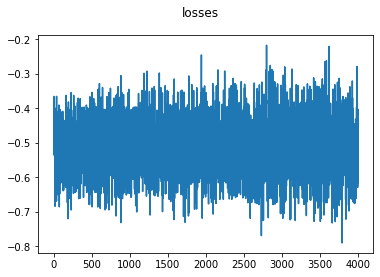

tensor([[1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.]]) yval
0 lineno1
tensor([1, 0, 1, 1, 1, 0, 0, 1, 1, 0]) y_val_updated
0 lineno2
0.5186094069529649 valid_accuracy
489 len(val_losses)


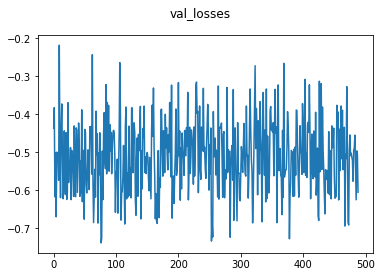

tensor([[0.7852, 0.2148],
        [0.7135, 0.2865],
        [0.8143, 0.1857],
        [0.8143, 0.1857],
        [0.8143, 0.1857],
        [0.8143, 0.1857],
        [0.7216, 0.2784],
        [0.8143, 0.1857],
        [0.8130, 0.1870],
        [0.7446, 0.2554]], grad_fn=<SoftmaxBackward>) yhat
0
tensor([[  1344,    374,    375,  ...,      0,      0,      0],
        [  1920,    311,    219,  ...,  18521,     20, 191717],
        [ 47166, 160856,   5047,  ...,      0,      0,      0],
        ...,
        [ 11456,     80,   9040,  ...,      0,      0,      0],
        [    39,   2405,   9431,  ...,      0,      0,      0],
        [232939,     80,   9040,  ...,   1609,    237,   3529]]) x_batch
tensor([[0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.]]) y_batch
tensor([[0.8160, 0.1840],
        [0.8161, 0.1839],
        [0.8161, 0.1839],
        [0.7695, 0.2305],
        [0.7317, 0.2683],
        [0.8161, 0.1

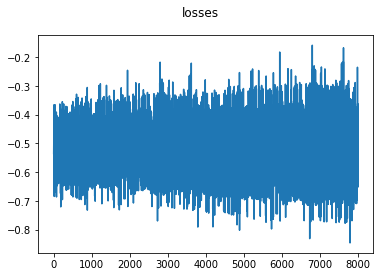

tensor([[1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.]]) yval
0 lineno1
tensor([1, 0, 1, 1, 1, 0, 0, 1, 1, 0]) y_val_updated
0 lineno2
0.518609406952965 valid_accuracy
978 len(val_losses)


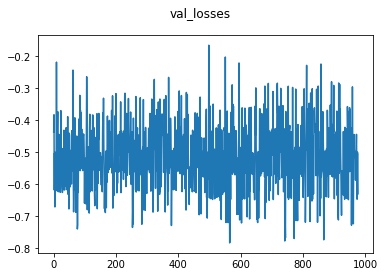

tensor([[0.8388, 0.1612],
        [0.7620, 0.2380],
        [0.8662, 0.1338],
        [0.8662, 0.1338],
        [0.8662, 0.1338],
        [0.8662, 0.1338],
        [0.7889, 0.2111],
        [0.8662, 0.1338],
        [0.8649, 0.1351],
        [0.8014, 0.1986]], grad_fn=<SoftmaxBackward>) yhat
0
tensor([[  1344,    374,    375,  ...,      0,      0,      0],
        [  1920,    311,    219,  ...,  18521,     20, 191717],
        [ 47166, 160856,   5047,  ...,      0,      0,      0],
        ...,
        [ 11456,     80,   9040,  ...,      0,      0,      0],
        [    39,   2405,   9431,  ...,      0,      0,      0],
        [232939,     80,   9040,  ...,   1609,    237,   3529]]) x_batch
tensor([[0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.]]) y_batch
tensor([[0.8674, 0.1326],
        [0.8675, 0.1325],
        [0.8675, 0.1325],
        [0.8315, 0.1685],
        [0.7936, 0.2064],
        [0.8675, 0.1

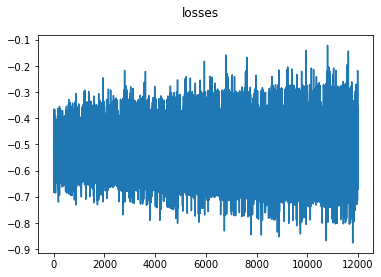

tensor([[1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.]]) yval
0 lineno1
tensor([1, 0, 1, 1, 1, 0, 0, 1, 1, 0]) y_val_updated
0 lineno2
0.5186094069529659 valid_accuracy
1467 len(val_losses)


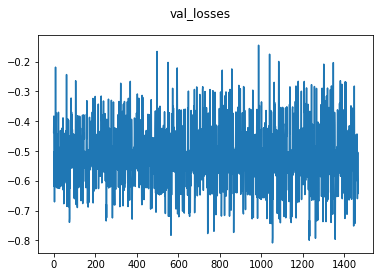

OrderedDict([('embedding.weight', tensor([[-0.1369, -0.2651,  0.4201,  ...,  0.3693,  0.9930, -0.4033],
        [ 0.0726, -0.5139,  0.4728,  ..., -0.1891, -0.5902,  0.5556],
        [ 0.6056, -1.0701,  1.1141,  ..., -0.0452,  0.4221,  0.1775],
        ...,
        [ 0.3230,  0.8263, -1.0287,  ..., -1.3893,  0.1735, -0.1911],
        [ 0.0469, -0.0180, -0.1875,  ..., -0.4879,  0.6600,  0.4085],
        [-0.2246, -0.0722,  0.0473,  ...,  0.0635,  0.2814,  0.2100]])), ('gru.weight_ih_l0', tensor([[-0.1178,  0.0750, -0.1621,  ..., -0.2519,  0.0876, -0.1885],
        [ 0.0444, -0.1321, -0.0226,  ..., -0.1250, -0.0472, -0.1916],
        [-0.0707,  0.0703, -0.2266,  ...,  0.1639,  0.0501, -0.0111],
        ...,
        [ 0.1547,  0.0371,  0.2391,  ..., -0.1766,  0.0677,  0.1759],
        [ 0.0692, -0.2492,  0.1493,  ...,  0.1858, -0.2025, -0.1705],
        [-0.0766,  0.2009,  0.1715,  ..., -0.0649, -0.1920,  0.0299]])), ('gru.weight_hh_l0', tensor([[-0.0844, -0.1254,  0.2352,  ...,  0.1981, -

In [196]:
import matplotlib.pyplot as plt


# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(toynet, loss_fn, optimizer)
losses = []
val_losses = []
accuracies = []
val_accuracies = []


# For each epoch...
for epoch in range(n_epochs):
    lineno = 0
    
    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
#         x_batch = x_batch.to(device)
#         y_batch = y_batch.to(device)
        

#         loss, batch_accuracy = train_step(x_batch, y_batch)
        loss, accuracy = train_step(x_batch, y_batch, lineno)
        losses.append(loss)
        accuracies.append(accuracy)
        
        if lineno % 100 == 0:
            print(lineno)
            print(x_batch, "x_batch")
            print(y_batch, "y_batch")
        lineno += 1
        
        # for some reason this is necessary to keep the epoch loop running
        # if lineno == batch_size, then break the train loop
#         if lineno == 5000:
#             break

    train_accuracy = sum(accuracies)/len(accuracies)
    print(train_accuracy, "train_accuracy")
        
    fig = plt.figure()
    fig.suptitle("losses")
    plt.plot(losses)
    plt.show()
            
        
            
    with torch.no_grad():
        lineno1 = 0
        lineno2 = 0
        
        for x_val, y_val in val_loader:
#             x_val = x_val.to(device)
#             y_val = y_val.to(device)
            
           
            # initialize accuracy counter (averaging these accuracies is accurate, as all batches are size 10)
            correct = 0
            total = len(x_val)
        
    
            if lineno1 % 1000 == 0:
                print(y_val, "yval")
                print(lineno1, "lineno1")
                
            lineno1 += 1
    
            toynet.eval()
        
            yhat = toynet(x_val, torch.zeros([20]))
            
            # convert yhat (tensor of lists) to single tensor
            init_tensor = y_val
#             print(init_tensor, "init_tensor")
            cat_list = []
            for val in enumerate(init_tensor):
#             print(val, "val")
                cat_list.append(val[1][0])
                if val[1][0] == torch.argmax(yhat[val[0]]):
#                 print(val[1][0], "target val")
#                 print(yhat[val[0]], "predicted val")
                    correct += 1
            y_val_updated = torch.LongTensor(cat_list)
        
            if lineno2 % 1000 == 0:
                print(y_val_updated, "y_val_updated")
                print(lineno2, "lineno2")
                
            lineno2 += 1
            
            # calculate accuracy
            val_accuracy = correct/total
            
            
            val_loss = loss_fn(yhat, y_val_updated)
            val_losses.append(val_loss.item())
           
            val_accuracies.append(val_accuracy)
        
        
        valid_accuracy = sum(val_accuracies)/len(val_accuracies)
        print(valid_accuracy, "valid_accuracy")
        
        print(len(val_losses), "len(val_losses)")
        fig = plt.figure()
        fig.suptitle("val_losses")
        plt.plot(val_losses)
        plt.show()
            
        
    
# Checks model's parameters
print(toynet.state_dict())

In [ ]:
import matplotlib.pyplot as plt
plt.plot(val_losses)